In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice((512, 4))

In [3]:
%%time
_ = mice.setup_dfs(mode='ca2', task='rest')

CPU times: user 130 ms, sys: 19 s, total: 19.1 s
Wall time: 19.1 s


In [5]:
%%time
_ = mice.setup_dfs(mode='bold', task='rest')

CPU times: user 257 ms, sys: 9.16 s, total: 9.42 s
Wall time: 9.42 s


In [8]:
len(mice.looper), len(mice.bold_dfs), len(mice.ca_dfs)

(254, 158, 162)

In [11]:
sorted(set(mice.ca_dfs).difference(set(mice.bold_dfs)))

[
    'sub-SLC03_ses-1_run-1',
    'sub-SLC05_ses-1_run-5',
    'sub-SLC08_ses-1_run-1',
    'sub-SLC10_ses-2_run-1'
]

In [12]:
%%time

net_ca = Network(
    mice=mice,
    key='sub-SLC',
    df=mice.ca_dfs['sub-SLC'],
    percentiles=np.linspace(50, 1, 50),
).fit_network(save=False)

[PROGRESS] fit: initiated

[PROGRESS] graphs: done

[PROGRESS] fit: done!

CPU times: user 41.6 s, sys: 50.5 s, total: 1min 32s
Wall time: 16min 20s


In [13]:
%%time

net_bold = Network(
    mice=mice,
    key='sub-SLC',
    df=mice.bold_dfs['sub-SLC'],
    percentiles=np.linspace(50, 1, 50),
).fit_network(save=False)

[PROGRESS] fit: initiated

[PROGRESS] graphs: done

[PROGRESS] fit: done!

CPU times: user 21min 3s, sys: 1min 57s, total: 23min 1s
Wall time: 1h 45s


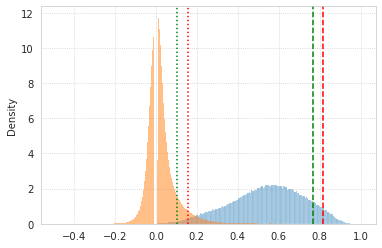

In [14]:
sns.histplot(net_ca.adj[net_ca.adj.nonzero()], color='C0', alpha=0.5, stat='density')
plt.axvline(net_ca.thresholds[10], color='g', ls='--')
plt.axvline(net_ca.thresholds[5], color='r', ls='--')

sns.histplot(net_bold.adj[net_bold.adj.nonzero()], color='C1', alpha=0.5, stat='density')
plt.axvline(net_bold.thresholds[10], color='g', ls=':')
plt.axvline(net_bold.thresholds[5], color='r', ls=':')

plt.show()

In [16]:
x = mice.ca_dfs['sub-SLC'].values
x.shape

(649000, 714)

In [17]:
nans = np.where(np.isnan(x).sum(0) > 0)[0]
x = np.delete(x, nans, axis=1)
x.shape

(649000, 369)

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(
    n_components=100,
    svd_solver='full',
).fit(x)

[<matplotlib.lines.Line2D object at 0x7f647e9a18b0>]

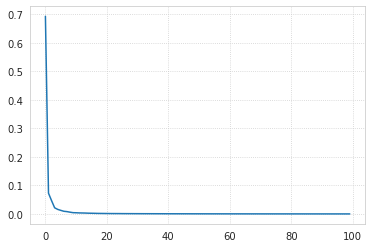

In [20]:
plt.plot(pca.explained_variance_ratio_)

In [21]:
pca.components_.shape

(100, 369)

In [22]:
y = pca.transform(x)
y.shape

(649000, 100)

[<matplotlib.lines.Line2D object at 0x7f647e9480d0>]

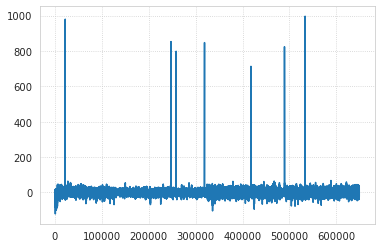

In [23]:
plt.plot(y[:, 0])

In [24]:
z = y.copy()
z[:, 0] = 0

x_inv = pca.inverse_transform(z)
x_inv.shape

(649000, 369)

In [25]:
df_new = pd.DataFrame(x_inv)
df_new.shape

(649000, 369)

In [26]:
a, p = get_adj_mat(df_new, 'pearson')

<matplotlib.colorbar.Colorbar object at 0x7f647c087850>

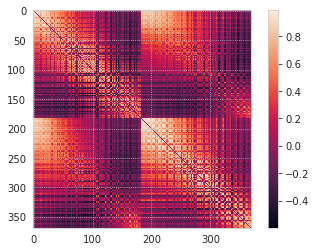

In [27]:
plt.imshow(a)
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f646e38dc10>

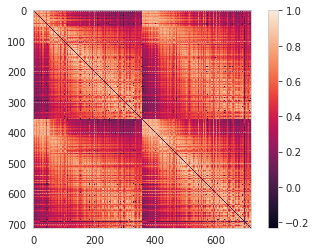

In [28]:
plt.imshow(net_ca.adj)
plt.colorbar()

<matplotlib.lines.Line2D object at 0x7f646e1b9280>

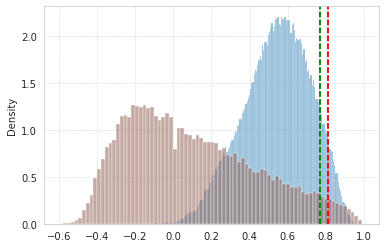

In [29]:
sns.histplot(net_ca.adj[net_ca.adj.nonzero()], color='C0', alpha=0.5, stat='density')
plt.axvline(net_ca.thresholds[10], color='g', ls='--')
plt.axvline(net_ca.thresholds[5], color='r', ls='--')

sns.histplot(a[a.nonzero()], color='C5', alpha=0.5, stat='density')
plt.axvline(net_ca.thresholds[10], color='g', ls='--')
plt.axvline(net_ca.thresholds[5], color='r', ls='--')

In [11]:
net.thresholds

{
    98: 0.0,
    39: 0.4596961313164675,
    38: 0.46755772154030734,
    37: 0.47538551495281406,
    36: 0.48314278498493396,
    35: 0.4908546803008632,
    34: 0.49850372856418645,
    33: 0.506194944039789,
    32: 0.5136423530178186,
    31: 0.520976073437181,
    30: 0.5284651184530391,
    29: 0.5361049080354121,
    28: 0.5436327397579448,
    27: 0.5512950480393234,
    26: 0.559196796603484,
    25: 0.5670990055912025,
    24: 0.5753843527531467,
    23: 0.5832870581209749,
    22: 0.5912638172552251,
    21: 0.5994104631201131,
    20: 0.6078178922959514,
    19: 0.6162389038161689,
    18: 0.6247950353278204,
    17: 0.6334174387610725,
    16: 0.6425657325779144,
    15: 0.6516203185650696,
    14: 0.6613518261007383,
    13: 0.6710841272312859,
    12: 0.6810881658135784,
    11: 0.6911960258655838,
    10: 0.7021876191664721,
    9: 0.7140151808982196,
    8: 0.7260408124425101,
    7: 0.7391410180842544,
    6: 0.7539200921370193,
    5: 0.7690181812588525,
    4: 0.7855247691201411,
    3: 0.8059617174147814,
    2: 0.8296872222403453,
    1: 0.8625828929968875
}

<matplotlib.colorbar.Colorbar object at 0x7fa72027d490>

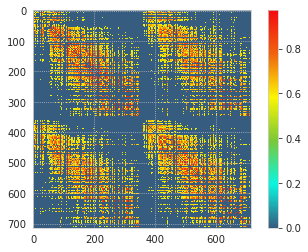

In [9]:
plt.imshow(net.adjacencies[31], cmap=net.style['cmap'])
plt.colorbar()

In [24]:
list(net.adjacencies)

[60, 49, 44, 40, 36, 31, 27, 23, 18, 14, 10]

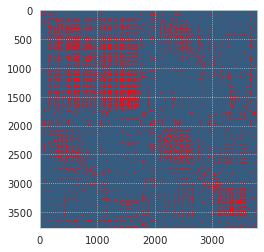

In [29]:
x = net.adjacencies[10].copy()
x[x.nonzero()] = 1
plt.imshow(x, cmap=net.style['cmap'])
plt.show()

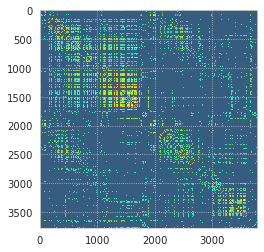

In [31]:
plt.imshow(net.adjacencies[10], cmap=net.style['cmap'])
plt.show()

In [ ]:
plt.imshow(net.adjacencies[10], cmap=net.style['cmap'])
plt.show()

In [34]:
list(net.l2n)[:15]

[
    '1-1-0',
    '1-1-1',
    '1-1-2',
    '1-1-3',
    '1-2-0',
    '1-2-1',
    '1-2-2',
    '1-3-0',
    '1-3-1',
    '1-3-2',
    '1-3-3',
    '1-4-0',
    '1-4-1',
    '1-4-2',
    '1-4-3'
]

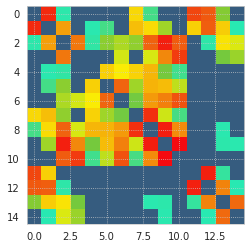

In [38]:
plt.imshow(net.adjacencies[10][:15][:, :15], cmap=net.style['cmap'])
plt.show()

In [45]:
net.set_percentiles(np.linspace(39, 1, 39), fit=False)

In [46]:
net._apply_thresholds()

In [47]:
net.thresholds

{
    39: 0.0,
    38: 0.0,
    37: 0.0,
    36: 0.0,
    35: 0.0,
    34: 0.0,
    33: 0.0,
    32: 0.0,
    31: 0.0,
    30: 0.0,
    29: 0.0,
    28: 0.08654204329874084,
    27: 0.09153389727785298,
    26: 0.09659859318672062,
    25: 0.10185478026645084,
    24: 0.10725231093893205,
    23: 0.11283949448491673,
    22: 0.11861724700840459,
    21: 0.1245859004785116,
    20: 0.1308128208160467,
    19: 0.1373160751033284,
    18: 0.14413159503511605,
    17: 0.1512302343411794,
    16: 0.15882949056106083,
    15: 0.1668067264055928,
    14: 0.17538187235224362,
    13: 0.18456917724749475,
    12: 0.19449683695954656,
    11: 0.205350498463946,
    10: 0.2172216889792347,
    9: 0.23044618121254315,
    8: 0.24525316018205426,
    7: 0.26225863988035447,
    6: 0.2820893186581125,
    5: 0.3057839987393555,
    4: 0.3354609953599896,
    3: 0.37488954593055895,
    2: 0.4317218264066186,
    1: 0.5261628433936266
}

<matplotlib.lines.Line2D object at 0x7f98b5b9a3d0>

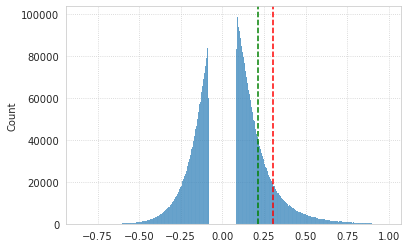

In [56]:
sns.histplot(net.adj[net.adj.nonzero()], color='C0')
plt.axvline(net.thresholds[10], color='g', ls='--')
plt.axvline(net.thresholds[5], color='r', ls='--')

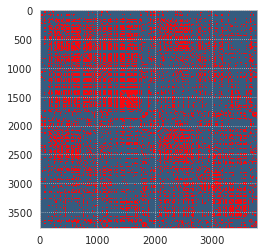

In [55]:
x = net.adjacencies[25].copy()
x[x.nonzero()] = 1
plt.imshow(x, cmap=net.style['cmap'])
plt.show()

In [3]:
df_stim = mice.load_stim_times('ca2')
df_stim

,key,mode,task,timepoint,stim
0,sub-SLC01_ses-1_run-1,ca2,rest,500,0
1,sub-SLC01_ses-1_run-1,ca2,rest,501,0
2,sub-SLC01_ses-1_run-1,ca2,rest,502,0
3,sub-SLC01_ses-1_run-1,ca2,rest,503,0
4,sub-SLC01_ses-1_run-1,ca2,rest,504,0
...,...,...,...,...,...
1154995,sub-SLC10_ses-3_run-7,ca2,rest,41995,0
1154996,sub-SLC10_ses-3_run-7,ca2,rest,41996,0
1154997,sub-SLC10_ses-3_run-7,ca2,rest,41997,0
1154998,sub-SLC10_ses-3_run-7,ca2,rest,41998,0


In [4]:
_df = df_stim.loc[df_stim['stim'] == 1]
_df = _df[_df['task'].values == 'rest']
_df

,key,mode,task,timepoint,stim
236706,sub-SLC03_ses-1_run-2,ca2,rest,6706,1
236707,sub-SLC03_ses-1_run-2,ca2,rest,6707,1
236708,sub-SLC03_ses-1_run-2,ca2,rest,6708,1
236709,sub-SLC03_ses-1_run-2,ca2,rest,6709,1
236710,sub-SLC03_ses-1_run-2,ca2,rest,6710,1
...,...,...,...,...,...
582963,sub-SLC06_ses-1_run-1,ca2,rest,5963,1
582964,sub-SLC06_ses-1_run-1,ca2,rest,5964,1
582965,sub-SLC06_ses-1_run-1,ca2,rest,5965,1
582966,sub-SLC06_ses-1_run-1,ca2,rest,5966,1


In [5]:
_df['key'].unique()

array(['sub-SLC03_ses-1_run-2', 'sub-SLC03_ses-1_run-4',
       'sub-SLC03_ses-1_run-6', 'sub-SLC06_ses-1_run-1'], dtype=object)

In [6]:
df_stim = mice.load_stim_times('bold')
df_stim

,key,mode,task,timepoint,stim
0,sub-SLC01_ses-1_run-1,bold,rest,50,0
1,sub-SLC01_ses-1_run-1,bold,rest,51,0
2,sub-SLC01_ses-1_run-1,bold,rest,52,0
3,sub-SLC01_ses-1_run-1,bold,rest,53,0
4,sub-SLC01_ses-1_run-1,bold,rest,54,0
...,...,...,...,...,...
115495,sub-SLC10_ses-3_run-7,bold,rest,4195,0
115496,sub-SLC10_ses-3_run-7,bold,rest,4196,0
115497,sub-SLC10_ses-3_run-7,bold,rest,4197,0
115498,sub-SLC10_ses-3_run-7,bold,rest,4198,0


In [11]:
save_obj(dfs, 'test_ca', tmp_dir, 'npy')

[PROGRESS] 'test_ca.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

'/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/test_ca.npy'

Warning, sub-SLC08_ses-1_run-1: 100 % of ROIs are nan. Moving on . . .

Warning, sub-SLC10_ses-2_run-1: 100 % of ROIs are nan. Moving on . . .

In [8]:
list(dfs)

[
    'sub-SLC01_ses-1_run-1',
    'sub-SLC01_ses-1_run-2',
    'sub-SLC01_ses-1_run-3',
    'sub-SLC01_ses-1_run-4',
    'sub-SLC01_ses-1_run-5',
    'sub-SLC01_ses-1_run-6',
    'sub-SLC01_ses-1_run-7',
    'sub-SLC01_ses-2_run-1',
    'sub-SLC01_ses-2_run-2',
    'sub-SLC01_ses-2_run-3',
    'sub-SLC01_ses-2_run-4',
    'sub-SLC01_ses-2_run-5',
    'sub-SLC01_ses-2_run-6',
    'sub-SLC01_ses-2_run-7',
    'sub-SLC01_ses-3_run-1',
    'sub-SLC01_ses-3_run-2',
    'sub-SLC01_ses-3_run-3',
    'sub-SLC01_ses-3_run-4',
    'sub-SLC01_ses-3_run-5',
    'sub-SLC01_ses-3_run-6',
    'sub-SLC01_ses-3_run-7',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC02_ses-1_run-2',
    'sub-SLC02_ses-1_run-3',
    'sub-SLC02_ses-1_run-4',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC02_ses-1_run-6',
    'sub-SLC02_ses-1_run-7',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC02_ses-2_run-2',
    'sub-SLC02_ses-2_run-3',
    'sub-SLC02_ses-2_run-4',
    'sub-SLC02_ses-2_run-5',
    'sub-SLC02_ses-2_run-6',
    'sub-SLC02_ses-2_run-7',
    'sub-SLC02_ses-3_run-1',
    'sub-SLC02_ses-3_run-2',
    'sub-SLC02_ses-3_run-3',
    'sub-SLC02_ses-3_run-4',
    'sub-SLC02_ses-3_run-5',
    'sub-SLC02_ses-3_run-6',
    'sub-SLC02_ses-3_run-7',
    'sub-SLC03_ses-1_run-2',
    'sub-SLC03_ses-1_run-3',
    'sub-SLC03_ses-1_run-4',
    'sub-SLC03_ses-1_run-5',
    'sub-SLC03_ses-1_run-6',
    'sub-SLC03_ses-1_run-7',
    'sub-SLC03_ses-2_run-1',
    'sub-SLC03_ses-2_run-2',
    'sub-SLC03_ses-2_run-3',
    'sub-SLC03_ses-2_run-4',
    'sub-SLC03_ses-2_run-5',
    'sub-SLC03_ses-2_run-6',
    'sub-SLC03_ses-2_run-7',
    'sub-SLC03_ses-3_run-1',
    'sub-SLC03_ses-3_run-2',
    'sub-SLC03_ses-3_run-3',
    'sub-SLC03_ses-3_run-4',
    'sub-SLC03_ses-3_run-5',
    'sub-SLC03_ses-3_run-6',
    'sub-SLC03_ses-3_run-7',
    'sub-SLC04_ses-1_run-1',
    'sub-SLC04_ses-1_run-2',
    'sub-SLC04_ses-1_run-3',
    'sub-SLC04_ses-1_run-4',
    'sub-SLC04_ses-1_run-5',
    'sub-SLC04_ses-1_run-6',
    'sub-SLC04_ses-1_run-7',
    'sub-SLC04_ses-2_run-1',
    'sub-SLC04_ses-2_run-2',
    'sub-SLC04_ses-2_run-3',
    'sub-SLC04_ses-2_run-4',
    'sub-SLC04_ses-2_run-5',
    'sub-SLC04_ses-2_run-6',
    'sub-SLC04_ses-2_run-7',
    'sub-SLC04_ses-3_run-1',
    'sub-SLC04_ses-3_run-2',
    'sub-SLC04_ses-3_run-3',
    'sub-SLC04_ses-3_run-4',
    'sub-SLC04_ses-3_run-5',
    'sub-SLC04_ses-3_run-6',
    'sub-SLC04_ses-3_run-7',
    'sub-SLC05_ses-1_run-1',
    'sub-SLC05_ses-1_run-2',
    'sub-SLC05_ses-1_run-3',
    'sub-SLC05_ses-1_run-4',
    'sub-SLC05_ses-1_run-6',
    'sub-SLC05_ses-1_run-7',
    'sub-SLC05_ses-2_run-1',
    'sub-SLC05_ses-2_run-2',
    'sub-SLC05_ses-2_run-3',
    'sub-SLC05_ses-2_run-4',
    'sub-SLC05_ses-2_run-5',
    'sub-SLC05_ses-2_run-6',
    'sub-SLC05_ses-2_run-7',
    'sub-SLC05_ses-3_run-1',
    'sub-SLC05_ses-3_run-2',
    'sub-SLC05_ses-3_run-3',
    'sub-SLC05_ses-3_run-4',
    'sub-SLC05_ses-3_run-5',
    'sub-SLC05_ses-3_run-6',
    'sub-SLC05_ses-3_run-7',
    'sub-SLC06_ses-1_run-1',
    'sub-SLC06_ses-1_run-2',
    'sub-SLC06_ses-1_run-3',
    'sub-SLC06_ses-1_run-4',
    'sub-SLC06_ses-1_run-5',
    'sub-SLC06_ses-1_run-6',
    'sub-SLC06_ses-1_run-7',
    'sub-SLC06_ses-2_run-1',
    'sub-SLC06_ses-2_run-2',
    'sub-SLC06_ses-2_run-3',
    'sub-SLC06_ses-2_run-4',
    'sub-SLC06_ses-2_run-5',
    'sub-SLC06_ses-2_run-6',
    'sub-SLC06_ses-2_run-7',
    'sub-SLC06_ses-3_run-1',
    'sub-SLC06_ses-3_run-3',
    'sub-SLC06_ses-3_run-4',
    'sub-SLC06_ses-3_run-5',
    'sub-SLC06_ses-3_run-6',
    'sub-SLC06_ses-3_run-7',
    'sub-SLC07_ses-1_run-1',
    'sub-SLC07_ses-1_run-2',
    'sub-SLC07_ses-1_run-3',
    'sub-SLC07_ses-1_run-4',
    'sub-SLC07_ses-1_run-5',
    'sub-SLC07_ses-1_run-6',
    'sub-SLC07_ses-1_run-7',
    'sub-SLC07_ses-2_run-1',
    'sub-SLC07_ses-2_run-2',
    'sub-SLC07_ses-2_run-3',
    'sub-SLC07_ses-2_run-4',
    'sub-SLC07_ses-2_run-5',
    'sub-SLC07_ses-2_run-6',
    'sub-SLC07_ses-2_run-7',
    'sub-SLC07_ses-3_run-

In [9]:
dfs['sub-SLC08_ses-2_run-6']

,1-1-0,1-1-1,1-1-2,1-1-3,1-2-0,1-2-1,1-2-2,1-3-0,1-3-1,1-3-2,...,2-1117,2-1181,2-1190,2-1340,2-1348,2-1384,2-1468,2-1477,2-10703,2-10704
0,-1.526114,-1.123256,-0.384068,0.398320,0.082983,-0.707161,-0.358813,-0.813930,-0.571135,-0.539468,...,0.006935,-0.018365,-0.690969,0.188608,0.041118,0.816416,0.206404,-0.083285,0.188996,0.212799
1,-0.999470,-0.771125,-0.221690,0.586310,0.250182,-0.421215,-0.333139,-0.591615,-0.501356,-0.565620,...,0.281852,0.000083,-0.846453,0.015305,0.049020,2.272807,0.230961,-0.138889,0.207585,0.460202
2,-1.010709,-0.627812,-0.197740,-0.106970,0.005876,-0.255059,-0.169416,-0.906733,-0.566456,-0.433143,...,0.547994,-0.063272,-0.513910,0.698663,0.114704,2.924990,0.204285,-0.114286,0.047973,0.682058
3,-1.050059,-0.673988,-0.412958,-0.651675,-0.406680,-0.108994,0.173293,-1.039044,-0.460769,-0.189692,...,0.404444,-0.184238,-0.039965,0.850809,-0.335678,2.197589,0.330612,-0.425086,-0.032830,0.720847
4,-0.798570,-0.620100,-0.464803,-0.438617,0.243223,0.394169,0.651075,-0.257043,0.103588,0.154897,...,0.014118,-0.170047,0.217204,0.313688,-0.769879,0.538688,0.081902,-0.848348,-0.052921,0.246625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,-0.402011,-0.643295,-0.066193,0.660793,0.295265,-0.031912,0.544939,0.106300,0.052934,0.235667,...,0.791342,-0.851664,-2.267433,2.267307,-0.373428,-0.617552,0.411402,0.508187,-0.141777,-0.521817
546,-0.579062,-0.840864,-0.724090,-0.168190,0.330755,0.015008,0.521496,-0.219729,-0.247686,-0.191756,...,0.468948,-0.656950,-2.001564,2.154106,0.289062,-0.417544,0.256559,-0.025419,0.048044,-0.135234
547,-0.542173,-1.106811,-1.376066,-0.849939,0.688232,0.128497,0.697837,-0.401291,-0.446153,-0.697414,...,0.232412,-0.563250,-2.134228,1.935040,0.694502,-0.655784,-0.000100,-0.321923,0.012765,-0.122355
548,-0.262104,-0.528175,-0.799930,-0.766228,1.309415,0.449718,0.913931,0.141753,0.194926,-0.227624,...,0.297035,-0.530549,-2.137424,1.635887,0.628107,-0.988999,0.031894,-0.094146,-0.167899,-0.307497


In [10]:
x = dfs['sub-SLC08_ses-2_run-6'].corr()
x = x.values
np.fill_diagonal(x, 0.)

<matplotlib.image.AxesImage object at 0x7f94de878be0>

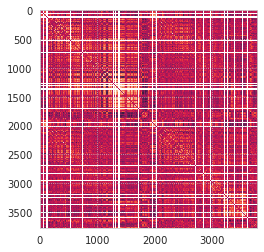

In [11]:
plt.imshow(x)

In [12]:
x.shape

(3776, 3776)

In [78]:
a, p = get_adj_mat(dfs['sub-SLC08_ses-2_run-6'], 'pearson')
aa, pp = get_adj_mat(dfs['sub-SLC08_ses-2_run-6'], 'spearman')

In [79]:
idxs_pears = np.where(np.abs(a).sum(0) == 0)[0]
idxs_spear = np.where(np.abs(aa).sum(0) == 0)[0]

In [80]:
a.shape, aa.shape

((3776, 3776), (3776, 3776))

<matplotlib.colorbar.Colorbar object at 0x7f933e4458b0>

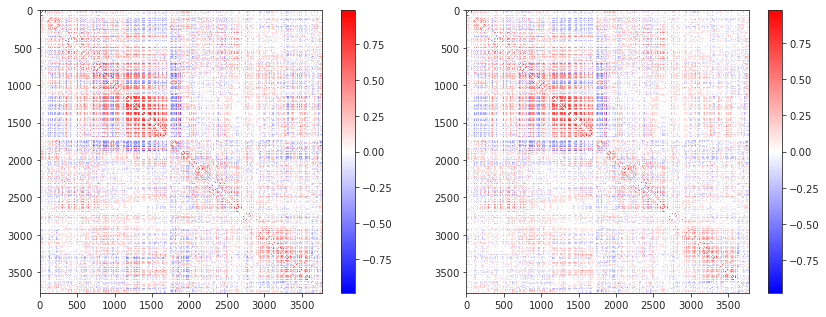

In [81]:
fig, axes = create_figure(1, 2, (12, 4.5))

vminmax = np.max(np.abs(a))
im = axes[0].imshow(a, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar(im, ax=axes[0])

vminmax = np.max(np.abs(aa))
im = axes[1].imshow(aa, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar(im, ax=axes[1])

<AxesSubplot:ylabel='Count'>

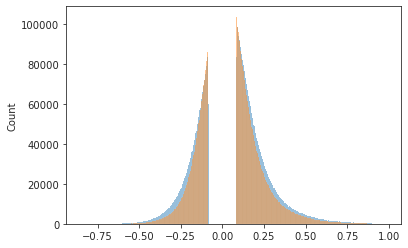

In [106]:
sns.histplot(a[a.nonzero()], color='C0', alpha=0.5)
sns.histplot(aa[aa.nonzero()], color='C1', alpha=0.5)

In [109]:
node_labels = dfs['sub-SLC08_ses-2_run-6'].columns.values

In [110]:
node_labels

[
    '1-1-0',
    '1-1-1',
    '1-1-2',
    '1-1-3',
    '1-2-0',
    '1-2-1',
    '1-2-2',
    '1-3-0',
    '1-3-1',
    '1-3-2',
    '1-3-3',
    '1-4-0',
    '1-4-1',
    '1-4-2',
    '1-4-3',
    '1-5-0',
    '1-5-1',
    '1-5-2',
    '1-6-0',
    '1-6-1',
    '1-6-2',
    '1-6-3',
    '1-7-0',
    '1-7-1',
    '1-7-2',
    '1-8-0',
    '1-8-1',
    '1-8-2',
    '1-9-0',
    '1-9-1',
    '1-9-2',
    '1-10-0',
    '1-10-1',
    '1-10-2',
    '1-10-3',
    '1-11-0',
    '1-11-1',
    '1-11-2',
    '1-12-0',
    '1-12-1',
    '1-12-2',
    '1-13-0',
    '1-13-1',
    '1-13-2',
    '1-14-0',
    '1-14-1',
    '1-15-0',
    '1-15-1',
    '1-15-2',
    '1-16-0',
    '1-16-1',
    '1-16-2',
    '1-17-0',
    '1-17-1',
    '1-17-2',
    '1-18-0',
    '1-18-1',
    '1-18-2',
    '1-19-0',
    '1-19-1',
    '1-19-2',
    '1-20-0',
    '1-20-1',
    '1-20-2',
    '1-21-0',
    '1-21-1',
    '1-22-0',
    '1-22-1',
    '1-22-2',
    '1-23-0',
    '1-23-1',
    '1-24-0',
    '1-24-1',
    '1-24-2',
    '1-25-0',
    '1-25-1',
    '1-26-0',
    '1-26-1',
    '1-26-2',
    '1-27-0',
    '1-27-1',
    '1-27-2',
    '1-28-0',
    '1-28-1',
    '1-28-2',
    '1-29-0',
    '1-29-1',
    '1-30-0',
    '1-30-1',
    '1-31-0',
    '1-31-1',
    '1-31-2',
    '1-32-0',
    '1-32-1',
    '1-32-2',
    '1-33-0',
    '1-33-1',
    '1-33-2',
    '1-33-3',
    '1-34-0',
    '1-34-1',
    '1-35-0',
    '1-35-1',
    '1-36-0',
    '1-36-1',
    '1-37-0',
    '1-37-1',
    '1-37-2',
    '1-37-3',
    '1-38-0',
    '1-38-1',
    '1-38-2',
    '1-39-0',
    '1-39-1',
    '1-39-2',
    '1-40-0',
    '1-40-1',
    '1-40-2',
    '1-41-0',
    '1-41-1',
    '1-41-2',
    '1-42-0',
    '1-42-1',
    '1-42-2',
    '1-43-0',
    '1-43-1',
    '1-44-0',
    '1-44-1',
    '1-44-2',
    '1-45-0',
    '1-46-0',
    '1-46-1',
    '1-47-0',
    '1-47-1',
    '1-47-2',
    '1-47-3',
    '1-48-0',
    '1-48-1',
    '1-48-2',
    '1-48-3',
    '1-49-0',
    '1-49-1',
    '1-49-2',
    '1-50-0',
    '1-50-1',
    '1-50-2',
    '1-51-0',
    '1-51-1',
    '1-51-2',
    '1-51-3',
    '1-52-0',
    '1-52-1',
    '1-53-0',
    '1-53-1',
    '1-53-2',
    '1-54-0',
    '1-54-1',
    '1-54-2',
    '1-54-3',
    '1-55-0',
    '1-55-1',
    '1-55-2',
    '1-56-0',
    '1-56-1',
    '1-57-0',
    '1-57-1',
    '1-58-0',
    '1-58-1',
    '1-58-2',
    '1-58-3',
    '1-59-0',
    '1-59-1',
    '1-60-0',
    '1-61-0',
    '1-62-0',
    '1-62-1',
    '1-62-2',
    '1-62-3',
    '1-63-0',
    '1-63-1',
    '1-63-2',
    '1-64-0',
    '1-64-1',
    '1-64-2',
    '1-64-3',
    '1-65-0',
    '1-65-1',
    '1-65-2',
    '1-65-3',
    '1-66-0',
    '1-66-1',
    '1-67-0',
    '1-67-1',
    '1-67-2',
    '1-67-3',
    '1-68-0',
    '1-68-1',
    '1-68-2',
    '1-68-3',
    '1-69-0',
    '1-69-1',
    '1-69-2',
    '1-70-0',
    '1-70-1',
    '1-70-2',
    '1-71-0',
    '1-71-1',
    '1-71-2',
    '1-72-0',
    '1-72-1',
    '1-73-0',
    '1-73-1',
    '1-73-2',
    '1-73-3',
    '1-74-0',
    '1-74-1',
    '1-75-0',
    '1-75-1',
    '1-76-0',
    '1-76-1',
    '1-76-2',
    '1-77-0',
    '1-78-0',
    '1-78-1',
    '1-78-2',
    '1-79-0',
    '1-79-1',
    '1-79-2',
    '1-79-3',
    '1-80-0',
    '1-80-1',
    '1-81-0',
    '1-81-1',
    '1-81-2',
    '1-81-3',
    '1-82-0',
    '1-82-1',
    '1-82-2',
    '1-82-3',
    '1-83-0',
    '1-83-1',
    '1-83-2',
    '1-83-3',
    '1-84-0',
    '1-84-1',
    '1-85-0',
    '1-85-1',
    '1-85-2',
    '1-85-3',
    '1-86-0',
    '1-86-1',
    '1-86-2',
    '1-87-0',
    '1-87-1',
    '1-87-2',
    '1-87-3',
    '1-88-0',
    '1-88-1',
    '1-88-2',
    '1-88-3',
    '1-89-0',
    '1-89-1',
    '1-89-2',
    '1-89-3',
    '1-90-0',
    '1-90-1',
    '1-90-2',
    '1-91-0',
    '1-91-1',
    '1-91-2',
    '1-91-3',
    '1-92-0',
    '1-92-1',
    '1-92-2',
    '1-93-0',
    '1-93-1',
    '1-93-2',
    '1-94-0',
    '1-94-1',
    '1-95-0',
    '1-95-1',
    '1-95-2',
    '1-95-3',
    '1-96-0',
    '1-96-1',
    '1-97-0',
    '1-97-1',
    '1-98-0

In [112]:
n2l = {i: lbl for i, lbl in enumerate(node_labels)}
l2n = {lbl: i for i, lbl in n2l.items()}

In [113]:
n2l

{
    0: '1-1-0',
    1: '1-1-1',
    2: '1-1-2',
    3: '1-1-3',
    4: '1-2-0',
    5: '1-2-1',
    6: '1-2-2',
    7: '1-3-0',
    8: '1-3-1',
    9: '1-3-2',
    10: '1-3-3',
    11: '1-4-0',
    12: '1-4-1',
    13: '1-4-2',
    14: '1-4-3',
    15: '1-5-0',
    16: '1-5-1',
    17: '1-5-2',
    18: '1-6-0',
    19: '1-6-1',
    20: '1-6-2',
    21: '1-6-3',
    22: '1-7-0',
    23: '1-7-1',
    24: '1-7-2',
    25: '1-8-0',
    26: '1-8-1',
    27: '1-8-2',
    28: '1-9-0',
    29: '1-9-1',
    30: '1-9-2',
    31: '1-10-0',
    32: '1-10-1',
    33: '1-10-2',
    34: '1-10-3',
    35: '1-11-0',
    36: '1-11-1',
    37: '1-11-2',
    38: '1-12-0',
    39: '1-12-1',
    40: '1-12-2',
    41: '1-13-0',
    42: '1-13-1',
    43: '1-13-2',
    44: '1-14-0',
    45: '1-14-1',
    46: '1-15-0',
    47: '1-15-1',
    48: '1-15-2',
    49: '1-16-0',
    50: '1-16-1',
    51: '1-16-2',
    52: '1-17-0',
    53: '1-17-1',
    54: '1-17-2',
    55: '1-18-0',
    56: '1-18-1',
    57: '1-18-2',
    58: '1-19-0',
    59: '1-19-1',
    60: '1-19-2',
    61: '1-20-0',
    62: '1-20-1',
    63: '1-20-2',
    64: '1-21-0',
    65: '1-21-1',
    66: '1-22-0',
    67: '1-22-1',
    68: '1-22-2',
    69: '1-23-0',
    70: '1-23-1',
    71: '1-24-0',
    72: '1-24-1',
    73: '1-24-2',
    74: '1-25-0',
    75: '1-25-1',
    76: '1-26-0',
    77: '1-26-1',
    78: '1-26-2',
    79: '1-27-0',
    80: '1-27-1',
    81: '1-27-2',
    82: '1-28-0',
    83: '1-28-1',
    84: '1-28-2',
    85: '1-29-0',
    86: '1-29-1',
    87: '1-30-0',
    88: '1-30-1',
    89: '1-31-0',
    90: '1-31-1',
    91: '1-31-2',
    92: '1-32-0',
    93: '1-32-1',
    94: '1-32-2',
    95: '1-33-0',
    96: '1-33-1',
    97: '1-33-2',
    98: '1-33-3',
    99: '1-34-0',
    100: '1-34-1',
    101: '1-35-0',
    102: '1-35-1',
    103: '1-36-0',
    104: '1-36-1',
    105: '1-37-0',
    106: '1-37-1',
    107: '1-37-2',
    108: '1-37-3',
    109: '1-38-0',
    110: '1-38-1',
    111: '1-38-2',
    112: '1-39-0',
    113: '1-39-1',
    114: '1-39-2',
    115: '1-40-0',
    116: '1-40-1',
    117: '1-40-2',
    118: '1-41-0',
    119: '1-41-1',
    120: '1-41-2',
    121: '1-42-0',
    122: '1-42-1',
    123: '1-42-2',
    124: '1-43-0',
    125: '1-43-1',
    126: '1-44-0',
    127: '1-44-1',
    128: '1-44-2',
    129: '1-45-0',
    130: '1-46-0',
    131: '1-46-1',
    132: '1-47-0',
    133: '1-47-1',
    134: '1-47-2',
    135: '1-47-3',
    136: '1-48-0',
    137: '1-48-1',
    138: '1-48-2',
    139: '1-48-3',
    140: '1-49-0',
    141: '1-49-1',
    142: '1-49-2',
    143: '1-50-0',
    144: '1-50-1',
    145: '1-50-2',
    146: '1-51-0',
    147: '1-51-1',
    148: '1-51-2',
    149: '1-51-3',
    150: '1-52-0',
    151: '1-52-1',
    152: '1-53-0',
    153: '1-53-1',
    154: '1-53-2',
    155: '1-54-0',
    156: '1-54-1',
    157: '1-54-2',
    158: '1-54-3',
    159: '1-55-0',
    160: '1-55-1',
    161: '1-55-2',
    162: '1-56-0',
    163: '1-56-1',
    164: '1-57-0',
    165: '1-57-1',
    166: '1-58-0',
    167: '1-58-1',
    168: '1-58-2',
    169: '1-58-3',
    170: '1-59-0',
    171: '1-59-1',
    172: '1-60-0',
    173: '1-61-0',
    174: '1-62-0',
    175: '1-62-1',
    176: '1-62-2',
    177: '1-62-3',
    178: '1-63-0',
    179: '1-63-1',
    180: '1-63-2',
    181: '1-64-0',
    182: '1-64-1',
    183: '1-64-2',
    184: '1-64-3',
    185: '1-65-0',
    186: '1-65-1',
    187: '1-65-2',
    188: '1-65-3',
    189: '1-66-0',
    190: '1-66-1',
    191: '1-67-0',
    192: '1-67-1',
    193: '1-67-2',
    194: '1-67-3',
    195: '1-68-0',
    196: '1-68-1',
    197: '1-68-2',
    198: '1-68-3',
    199: '1-69-0',
    200: '1-69-1',
    201: '1-69-2',
    202: '1-70-0',
    203: '1-70-1',
    204: '1-70-2',
    205: '1-71-0',
    206: '1-71-1',
    207: '1-71-2',
    208: '1-72-0',
    209: '1-72-1',
    210: '1-73-0',
    211: '1-73-1',
    212: '1-73-2',
    213: '1-73-3',
    214: '1-74-0',
    215: '1-74-1',
    216: '1-75-0',
    217: '1-75-1

In [10]:
dfs = mice.make_dfs('ca2')

In [12]:
y = dfs['sub-SLC08_ses-2_run-6'].corr()
y = y.values
np.fill_diagonal(y, 0.)

<matplotlib.image.AxesImage object at 0x7fbeade45c70>

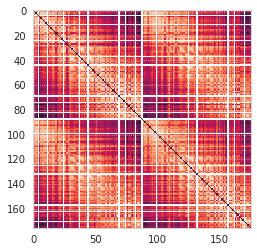

In [13]:
plt.imshow(y)

In [21]:
np.isnan(y).sum(1)

array([175,  17,  17,  17, 175,  17,  17,  17,  17,  17,  17, 175,  17,
        17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17, 175,  17,
        17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17, 175,  17,
        17,  17,  17,  17,  17, 175,  17,  17,  17,  17,  17,  17,  17,
        17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
        17,  17,  17,  17, 175,  17,  17,  17,  17, 175,  17,  17,  17,
        17,  17,  17,  17, 175,  17,  17,  17,  17, 175, 175,  17,  17,
        17,  17,  17,  17,  17,  17,  17,  17, 175,  17,  17,  17,  17,
        17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
        17,  17,  17,  17,  17,  17,  17,  17, 175,  17,  17,  17,  17,
        17,  17, 175,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
        17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
        17, 175,  17,  17,  17,  17, 175,  17,  17,  17,  17,  17,  17,
        17, 175,  17,  17,  17,  17,  17])

In [22]:
aaa = np.where(np.isnan(y).sum(1) > 100)[0]
aaa

array([  0,   4,  11,  24,  37,  44,  69,  74,  82,  87,  88,  99, 125,
       132, 157, 162, 170])

In [27]:
bbb = dfs['sub-SLC08_ses-2_run-6'].columns[aaa]
bbb

Index(['1-4-0', '1-14-0', '1-24-0', '1-43-0', '1-63-0', '1-72-0', '1-107-0',
       '1-112-0', '1-120-0', '1-126-0', '2-4-0', '2-24-0', '2-63-0', '2-72-0',
       '2-107-0', '2-112-0', '2-120-0'],
      dtype='object')

In [28]:
ca_func = mice.ca['sub-SLC08_ses-2_run-6'].get_data()

In [29]:
{k: v for k, v in ca_func.items() if k in bbb}

{
    '1-4-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '1-14-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '1-24-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '1-43-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '1-63-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '1-72-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '1-107-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '1-112-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '1-120-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '1-126-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '2-4-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '2-24-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '2-63-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '2-72-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '2-107-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '2-112-0': array([nan, nan, nan, ..., nan, nan, nan]),
    '2-120-0': array([nan, nan, nan, ..., nan, nan, nan])
}

<AxesSubplot:ylabel='Count'>

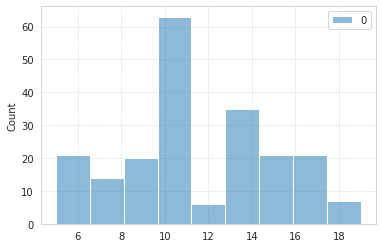

In [29]:
sns.histplot(perc_missing.values())

In [14]:
mice.setup_func_data()

In [31]:
x = mice.ca['sub-SLC01_ses-2_run-3'].get_data()

In [32]:
list(x)

[
    '1-4-0',
    '1-10-0',
    '1-12-0',
    '1-13-0',
    '1-14-0',
    '1-15-0',
    '1-17-0',
    '1-19-0',
    '1-20-0',
    '1-21-0',
    '1-22-0',
    '1-24-0',
    '1-26-0',
    '1-27-0',
    '1-28-0',
    '1-29-0',
    '1-33-0',
    '1-34-0',
    '1-35-0',
    '1-36-0',
    '1-37-0',
    '1-39-0',
    '1-41-0',
    '1-42-0',
    '1-43-0',
    '1-45-0',
    '1-46-0',
    '1-48-0',
    '1-49-0',
    '1-50-0',
    '1-53-0',
    '1-54-0',
    '1-55-0',
    '1-57-0',
    '1-58-0',
    '1-59-0',
    '1-61-0',
    '1-63-0',
    '1-64-0',
    '1-65-0',
    '1-67-0',
    '1-68-0',
    '1-70-0',
    '1-71-0',
    '1-72-0',
    '1-74-0',
    '1-75-0',
    '1-76-0',
    '1-78-0',
    '1-79-0',
    '1-81-0',
    '1-82-0',
    '1-84-0',
    '1-85-0',
    '1-86-0',
    '1-88-0',
    '1-90-0',
    '1-92-0',
    '1-93-0',
    '1-94-0',
    '1-95-0',
    '1-96-0',
    '1-97-0',
    '1-98-0',
    '1-101-0',
    '1-102-0',
    '1-103-0',
    '1-104-0',
    '1-105-0',
    '1-107-0',
    '1-108-0',
    '1-109-0',
    '1-110-0',
    '1-111-0',
    '1-112-0',
    '1-113-0',
    '1-114-0',
    '1-115-0',
    '1-116-0',
    '1-117-0',
    '1-118-0',
    '1-119-0',
    '1-120-0',
    '1-121-0',
    '1-122-0',
    '1-123-0',
    '1-125-0',
    '1-126-0',
    '2-4-0',
    '2-10-0',
    '2-12-0',
    '2-13-0',
    '2-14-0',
    '2-15-0',
    '2-17-0',
    '2-19-0',
    '2-20-0',
    '2-21-0',
    '2-22-0',
    '2-24-0',
    '2-26-0',
    '2-27-0',
    '2-28-0',
    '2-29-0',
    '2-33-0',
    '2-34-0',
    '2-35-0',
    '2-36-0',
    '2-37-0',
    '2-39-0',
    '2-41-0',
    '2-42-0',
    '2-43-0',
    '2-45-0',
    '2-46-0',
    '2-48-0',
    '2-49-0',
    '2-50-0',
    '2-53-0',
    '2-54-0',
    '2-55-0',
    '2-57-0',
    '2-58-0',
    '2-59-0',
    '2-61-0',
    '2-63-0',
    '2-64-0',
    '2-65-0',
    '2-67-0',
    '2-68-0',
    '2-70-0',
    '2-71-0',
    '2-72-0',
    '2-74-0',
    '2-75-0',
    '2-76-0',
    '2-78-0',
    '2-79-0',
    '2-81-0',
    '2-82-0',
    '2-84-0',
    '2-85-0',
    '2-86-0',
    '2-88-0',
    '2-90-0',
    '2-92-0',
    '2-93-0',
    '2-94-0',
    '2-95-0',
    '2-96-0',
    '2-97-0',
    '2-98-0',
    '2-101-0',
    '2-102-0',
    '2-103-0',
    '2-104-0',
    '2-105-0',
    '2-107-0',
    '2-108-0',
    '2-109-0',
    '2-110-0',
    '2-111-0',
    '2-112-0',
    '2-113-0',
    '2-114-0',
    '2-115-0',
    '2-116-0',
    '2-117-0',
    '2-118-0',
    '2-119-0',
    '2-120-0',
    '2-121-0',
    '2-122-0',
    '2-123-0',
    '2-125-0',
    '2-126-0'
]

In [33]:
def _reindex_fn(s):
    vals = tuple(map(lambda e: int(e), s.split('-')))
    i = int(vals[0] * 2e9) + vals[-1]
    if len(vals) == 3:
        i += int(vals[1] * 10)
    return i + int(6e6 / len(vals))

In [34]:
sorted(x, key=_reindex_fn)

[
    '1-4-0',
    '1-10-0',
    '1-12-0',
    '1-13-0',
    '1-14-0',
    '1-15-0',
    '1-17-0',
    '1-19-0',
    '1-20-0',
    '1-21-0',
    '1-22-0',
    '1-24-0',
    '1-26-0',
    '1-27-0',
    '1-28-0',
    '1-29-0',
    '1-33-0',
    '1-34-0',
    '1-35-0',
    '1-36-0',
    '1-37-0',
    '1-39-0',
    '1-41-0',
    '1-42-0',
    '1-43-0',
    '1-45-0',
    '1-46-0',
    '1-48-0',
    '1-49-0',
    '1-50-0',
    '1-53-0',
    '1-54-0',
    '1-55-0',
    '1-57-0',
    '1-58-0',
    '1-59-0',
    '1-61-0',
    '1-63-0',
    '1-64-0',
    '1-65-0',
    '1-67-0',
    '1-68-0',
    '1-70-0',
    '1-71-0',
    '1-72-0',
    '1-74-0',
    '1-75-0',
    '1-76-0',
    '1-78-0',
    '1-79-0',
    '1-81-0',
    '1-82-0',
    '1-84-0',
    '1-85-0',
    '1-86-0',
    '1-88-0',
    '1-90-0',
    '1-92-0',
    '1-93-0',
    '1-94-0',
    '1-95-0',
    '1-96-0',
    '1-97-0',
    '1-98-0',
    '1-101-0',
    '1-102-0',
    '1-103-0',
    '1-104-0',
    '1-105-0',
    '1-107-0',
    '1-108-0',
    '1-109-0',
    '1-110-0',
    '1-111-0',
    '1-112-0',
    '1-113-0',
    '1-114-0',
    '1-115-0',
    '1-116-0',
    '1-117-0',
    '1-118-0',
    '1-119-0',
    '1-120-0',
    '1-121-0',
    '1-122-0',
    '1-123-0',
    '1-125-0',
    '1-126-0',
    '2-4-0',
    '2-10-0',
    '2-12-0',
    '2-13-0',
    '2-14-0',
    '2-15-0',
    '2-17-0',
    '2-19-0',
    '2-20-0',
    '2-21-0',
    '2-22-0',
    '2-24-0',
    '2-26-0',
    '2-27-0',
    '2-28-0',
    '2-29-0',
    '2-33-0',
    '2-34-0',
    '2-35-0',
    '2-36-0',
    '2-37-0',
    '2-39-0',
    '2-41-0',
    '2-42-0',
    '2-43-0',
    '2-45-0',
    '2-46-0',
    '2-48-0',
    '2-49-0',
    '2-50-0',
    '2-53-0',
    '2-54-0',
    '2-55-0',
    '2-57-0',
    '2-58-0',
    '2-59-0',
    '2-61-0',
    '2-63-0',
    '2-64-0',
    '2-65-0',
    '2-67-0',
    '2-68-0',
    '2-70-0',
    '2-71-0',
    '2-72-0',
    '2-74-0',
    '2-75-0',
    '2-76-0',
    '2-78-0',
    '2-79-0',
    '2-81-0',
    '2-82-0',
    '2-84-0',
    '2-85-0',
    '2-86-0',
    '2-88-0',
    '2-90-0',
    '2-92-0',
    '2-93-0',
    '2-94-0',
    '2-95-0',
    '2-96-0',
    '2-97-0',
    '2-98-0',
    '2-101-0',
    '2-102-0',
    '2-103-0',
    '2-104-0',
    '2-105-0',
    '2-107-0',
    '2-108-0',
    '2-109-0',
    '2-110-0',
    '2-111-0',
    '2-112-0',
    '2-113-0',
    '2-114-0',
    '2-115-0',
    '2-116-0',
    '2-117-0',
    '2-118-0',
    '2-119-0',
    '2-120-0',
    '2-121-0',
    '2-122-0',
    '2-123-0',
    '2-125-0',
    '2-126-0'
]

In [3]:
from register.register import Register
reg = Register(mice)

In [ ]:
reg.organize_func(0.1)

logger 'organize_func_(2021_10_12).log' created at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*2/log

Name: cortex-merged . . . a total of 176 regions were accepted.
accept ratio: 85 %, reject ratio: 15 %, using a presence threshold of 10.0 %

organizing ca2:  sub-SLC07_ses-2_run-7:  66%|██████▌   | 139/210 [1:03:47<34:58, 29.55s/it]

In [12]:
reg.set_mode('3d')
acc = reg.get_accepted_regions(0.1)
{k: len(v) for k, v in acc.items()}

Name: cortex-merged . . . a total of 5368 regions were accepted.
accept ratio: 98 %, reject ratio: 2 %, using a presence threshold of 10.0 %

Name: subcortex-l . . . a total of 154 regions were accepted.
accept ratio: 100 %, reject ratio: 0 %, using a presence threshold of 10.0 %

Name: subcortex-r . . . a total of 154 regions were accepted.
accept ratio: 100 %, reject ratio: 0 %, using a presence threshold of 10.0 %

{'cortex-merged': 5368, 'subcortex-l': 154, 'subcortex-r': 154, 'subcortex': 154}

In [13]:
cor3d = acc['cortex-merged']

In [14]:
reg.set_mode('2d')
acc2 = reg.get_accepted_regions(0.1)
{k: len(v) for k, v in acc2.items()}

cor2d = acc2['cortex-merged']

Name: cortex-merged . . . a total of 1020 regions were accepted.
accept ratio: 72 %, reject ratio: 28 %, using a presence threshold of 10.0 %

In [15]:
[i for i in cor2d if i not in cor3d]

[]

In [26]:
thres = 0.1

regions_all = {}
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        mask = mice.mask3d[key].load_ants('unsigned int')
        mask = mask.numpy().astype(bool)
        obj = reg.load_obj_masks(key)
        x = obj['cortex-merged'].numpy()
        x *= mask
        regions = np.unique(x[x.nonzero()])
        regions_all[key] = sorted(regions)

regions_agg = []
for item in regions_all.values():
    regions_agg += item
freq = collections.Counter(regions_agg)
freq = {
    i: v / len(regions_all)
    for i, v in freq.items()
}
freq = {
    i: freq.get(i, 0.0) for i in
    mice.parcel.complement(list(freq))
}

rej = dict(filter(
    lambda t: t[1] < thres,
    freq.items()
))
rej = mice.parcel.complement(sorted(rej))
acc = [
    i for i in freq
    if i not in rej
]

msg = '\n\n'
msg += f"Name: {'cortex-merged'} . . . a total of {len(acc)} regions were accepted.\n"
msg += f"accept ratio: {100 * len(acc) / len(freq):0.0f} %, "
msg += f"reject ratio: {100 * len(rej) / len(freq):0.0f} %, "
msg += f"using a presence threshold of {0.1 * 100} %\n"

print(msg)

Name: cortex-merged . . . a total of 5368 regions were accepted.
accept ratio: 98 %, reject ratio: 2 %, using a presence threshold of 10.0 %

Name: cortex-merged . . . a total of 5368 regions were accepted.
accept ratio: 98 %, reject ratio: 2 %, using a presence threshold of 10.0 %

<AxesSubplot:ylabel='Proportion'>

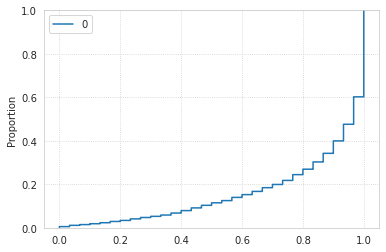

In [12]:
sns.ecdfplot(freq.values())

In [4]:

list(obj)

['cortex-merged', 'subcortex-l', 'subcortex-r', 'CH']

array([   1,    2,    3, ..., 6074, 6079, 6098], dtype=uint32)

In [ ]:
regions_all = {}


[PROGRESS] fit columnar: initiated

[PROGRESS] downsample: done

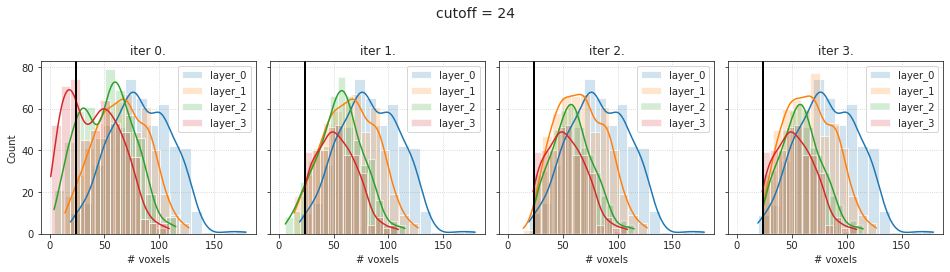

[PROGRESS] merge: done

Warning, region '163' is flat

Warning, region '178' is flat

Warning, region '193' is flat

[PROGRESS] erode: done

num merged regions,     left: 923,  right: 923
region id diff,         r - l:  Counter({1024: 923})

[PROGRESS] fit columnar: done

[PROGRESS] 'parcel_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*4

[PROGRESS] save results: done.

In [3]:
mice.parcel.fit_parcel(True, cutoff=3)

In [4]:
from register.register import Register
reg = Register(mice)

In [5]:
reg.register_anat(True)

registering anat sub-SLC10_ses-3: 100%|██████████| 30/30 [14:13<00:00, 28.44s/it]


In [6]:
reg.organize_func()

organizing bold:  sub-SLC01_ses-2_run-1:   3%|▎         | 7/210 [01:39<46:21, 13.70s/it]  /home/hadi/Dropbox/git/_Ca-fMRI/register/register.py:827: RuntimeWarning:

Mean of empty slice.

/home/hadi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning:

invalid value encountered in true_divide



Warnin! doing sub-SLC01_ses-2_run-1, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-2:   4%|▍         | 8/210 [01:53<45:49, 13.61s/it]

Warnin! doing sub-SLC01_ses-2_run-2, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-3:   4%|▍         | 9/210 [02:06<45:16, 13.51s/it]

Warnin! doing sub-SLC01_ses-2_run-3, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-4:   5%|▍         | 10/210 [02:20<45:01, 13.51s/it]

Warnin! doing sub-SLC01_ses-2_run-4, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-5:   5%|▌         | 11/210 [02:32<44:00, 13.27s/it]

Warnin! doing sub-SLC01_ses-2_run-5, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-6:   6%|▌         | 12/210 [02:45<43:37, 13.22s/it]

Warnin! doing sub-SLC01_ses-2_run-6, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC01_ses-2_run-7:   6%|▌         | 13/210 [02:58<42:50, 13.05s/it]

Warnin! doing sub-SLC01_ses-2_run-7, but empty mask found at '1042' = 2-18-0

organizing bold:  sub-SLC04_ses-2_run-1:  33%|███▎      | 70/210 [13:11<30:54, 13.25s/it]

Warnin! doing sub-SLC04_ses-2_run-1, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-2:  34%|███▍      | 71/210 [13:24<30:42, 13.26s/it]

Warnin! doing sub-SLC04_ses-2_run-2, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-3:  34%|███▍      | 72/210 [13:37<30:24, 13.22s/it]

Warnin! doing sub-SLC04_ses-2_run-3, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-4:  35%|███▍      | 73/210 [13:50<30:08, 13.20s/it]

Warnin! doing sub-SLC04_ses-2_run-4, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-5:  35%|███▌      | 74/210 [14:03<29:47, 13.14s/it]

Warnin! doing sub-SLC04_ses-2_run-5, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-6:  36%|███▌      | 75/210 [14:16<29:36, 13.16s/it]

Warnin! doing sub-SLC04_ses-2_run-6, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC04_ses-2_run-7:  36%|███▌      | 76/210 [14:30<29:29, 13.20s/it]

Warnin! doing sub-SLC04_ses-2_run-7, but empty mask found at '1080' = 2-56-0

organizing bold:  sub-SLC07_ses-3_run-1:  67%|██████▋   | 140/210 [29:10<16:26, 14.09s/it]

Warnin! doing sub-SLC07_ses-3_run-1, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-2:  67%|██████▋   | 141/210 [29:24<16:10, 14.06s/it]

Warnin! doing sub-SLC07_ses-3_run-2, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-3:  68%|██████▊   | 142/210 [29:37<15:36, 13.77s/it]

Warnin! doing sub-SLC07_ses-3_run-3, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-4:  68%|██████▊   | 143/210 [29:50<15:19, 13.72s/it]

Warnin! doing sub-SLC07_ses-3_run-4, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-5:  69%|██████▊   | 144/210 [30:05<15:17, 13.90s/it]

Warnin! doing sub-SLC07_ses-3_run-5, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-6:  69%|██████▉   | 145/210 [30:20<15:24, 14.22s/it]

Warnin! doing sub-SLC07_ses-3_run-6, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC07_ses-3_run-7:  70%|██████▉   | 146/210 [30:35<15:27, 14.49s/it]

Warnin! doing sub-SLC07_ses-3_run-7, but empty mask found at '15' = 1-15-0

organizing bold:  sub-SLC08_ses-1_run-1:  70%|███████   | 147/210 [30:49<15:02, 14.33s/it]

Warnin! doing sub-SLC08_ses-1_run-1, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC08_ses-1_run-2:  70%|███████   | 148/210 [31:03<14:38, 14.17s/it]

Warnin! doing sub-SLC08_ses-1_run-2, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC08_ses-1_run-3:  71%|███████   | 149/210 [31:17<14:33, 14.32s/it]

Warnin! doing sub-SLC08_ses-1_run-3, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC08_ses-1_run-4:  71%|███████▏  | 150/210 [31:32<14:29, 14.49s/it]

Warnin! doing sub-SLC08_ses-1_run-4, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC08_ses-1_run-5:  72%|███████▏  | 151/210 [31:46<14:05, 14.33s/it]

Warnin! doing sub-SLC08_ses-1_run-5, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC08_ses-1_run-6:  72%|███████▏  | 152/210 [31:59<13:23, 13.86s/it]

Warnin! doing sub-SLC08_ses-1_run-6, but empty mask found at '1050' = 2-26-0

organizing bold:  sub-SLC10_ses-3_run-7: 100%|██████████| 210/210 [45:30<00:00, 13.00s/it]


In [3]:
path = '/home/hadi/Documents/workspaces/allen/MouseConnectivity/cortical_coordinates'
sorted(os.listdir(path))

[
    'dorsal_flatmap_paths_10.h5',
    'isocortex_boundary_10.nrrd',
    'laplacian_10.nrrd',
    'top_view_paths_10.h5'
]

In [5]:
laplacian, laplacian_header = nrrd.read(pjoin(path, 'laplacian_10.nrrd'))

In [6]:
laplacian.shape

(1320, 800, 1140)

In [7]:
laplacian_header

OrderedDict([('type', 'float'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([1320,  800, 1140])), ('space directions', array([[10.,  0.,  0.],
       [ 0., 10.,  0.],
       [ 0.,  0., 10.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])

<matplotlib.image.AxesImage object at 0x7f3297ac18b0>

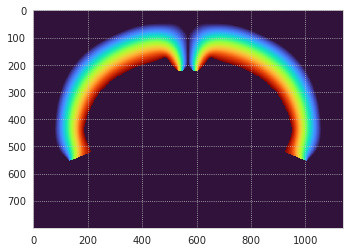

In [10]:
plt.imshow(laplacian[600], cmap='turbo')

In [11]:
boundary, boundary_header = nrrd.read(pjoin(path, 'isocortex_boundary_10.nrrd'))

In [22]:
import h5py

In [45]:
with h5py.File(pjoin(path, 'top_view_paths_10.h5'), 'r') as f:
    paths = np.array(f['paths'])
    view = np.array(f['view lookup'])
paths.shape, view.shape

((713732, 200), (1320, 1140))

<matplotlib.colorbar.Colorbar object at 0x7f3296611790>

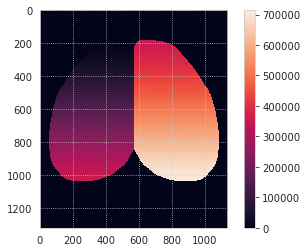

In [53]:
plt.imshow(view)
plt.colorbar()

In [51]:
with h5py.File(pjoin(path, 'dorsal_flatmap_paths_10.h5'), 'r') as f:
    dorsal_paths = np.array(f['paths'])
    dorsal_view = np.array(f['view lookup'])
dorsal_paths.shape, dorsal_view.shape

((2029520, 200), (1360, 2720))

<matplotlib.image.AxesImage object at 0x7f329664e970>

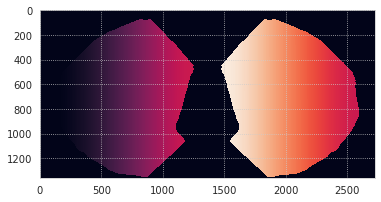

In [52]:
plt.imshow(dorsal_view)